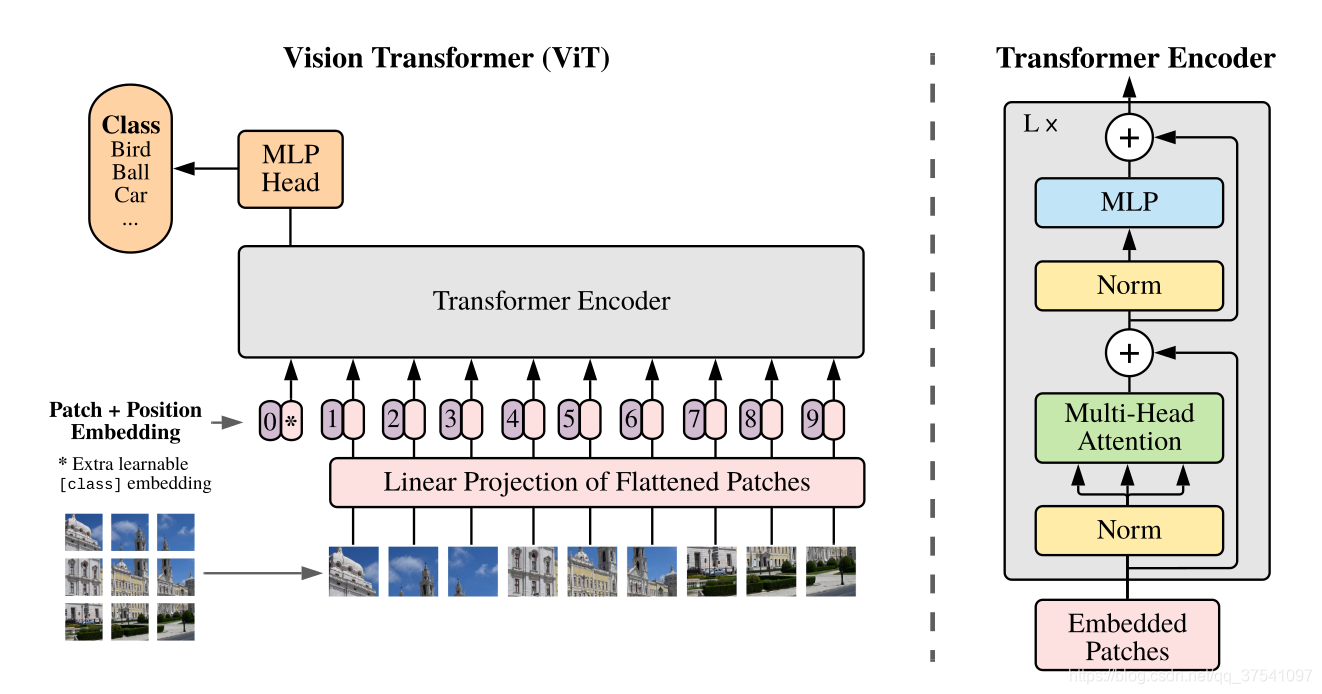

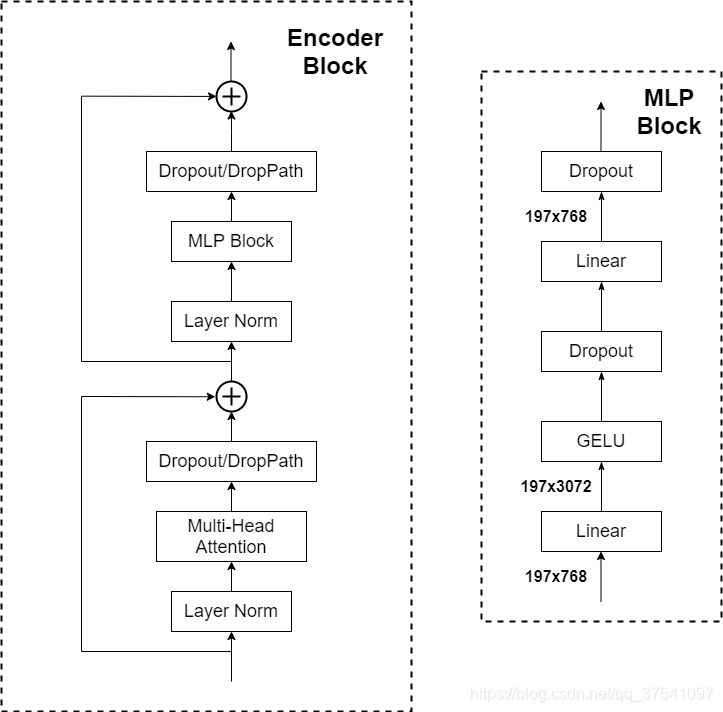

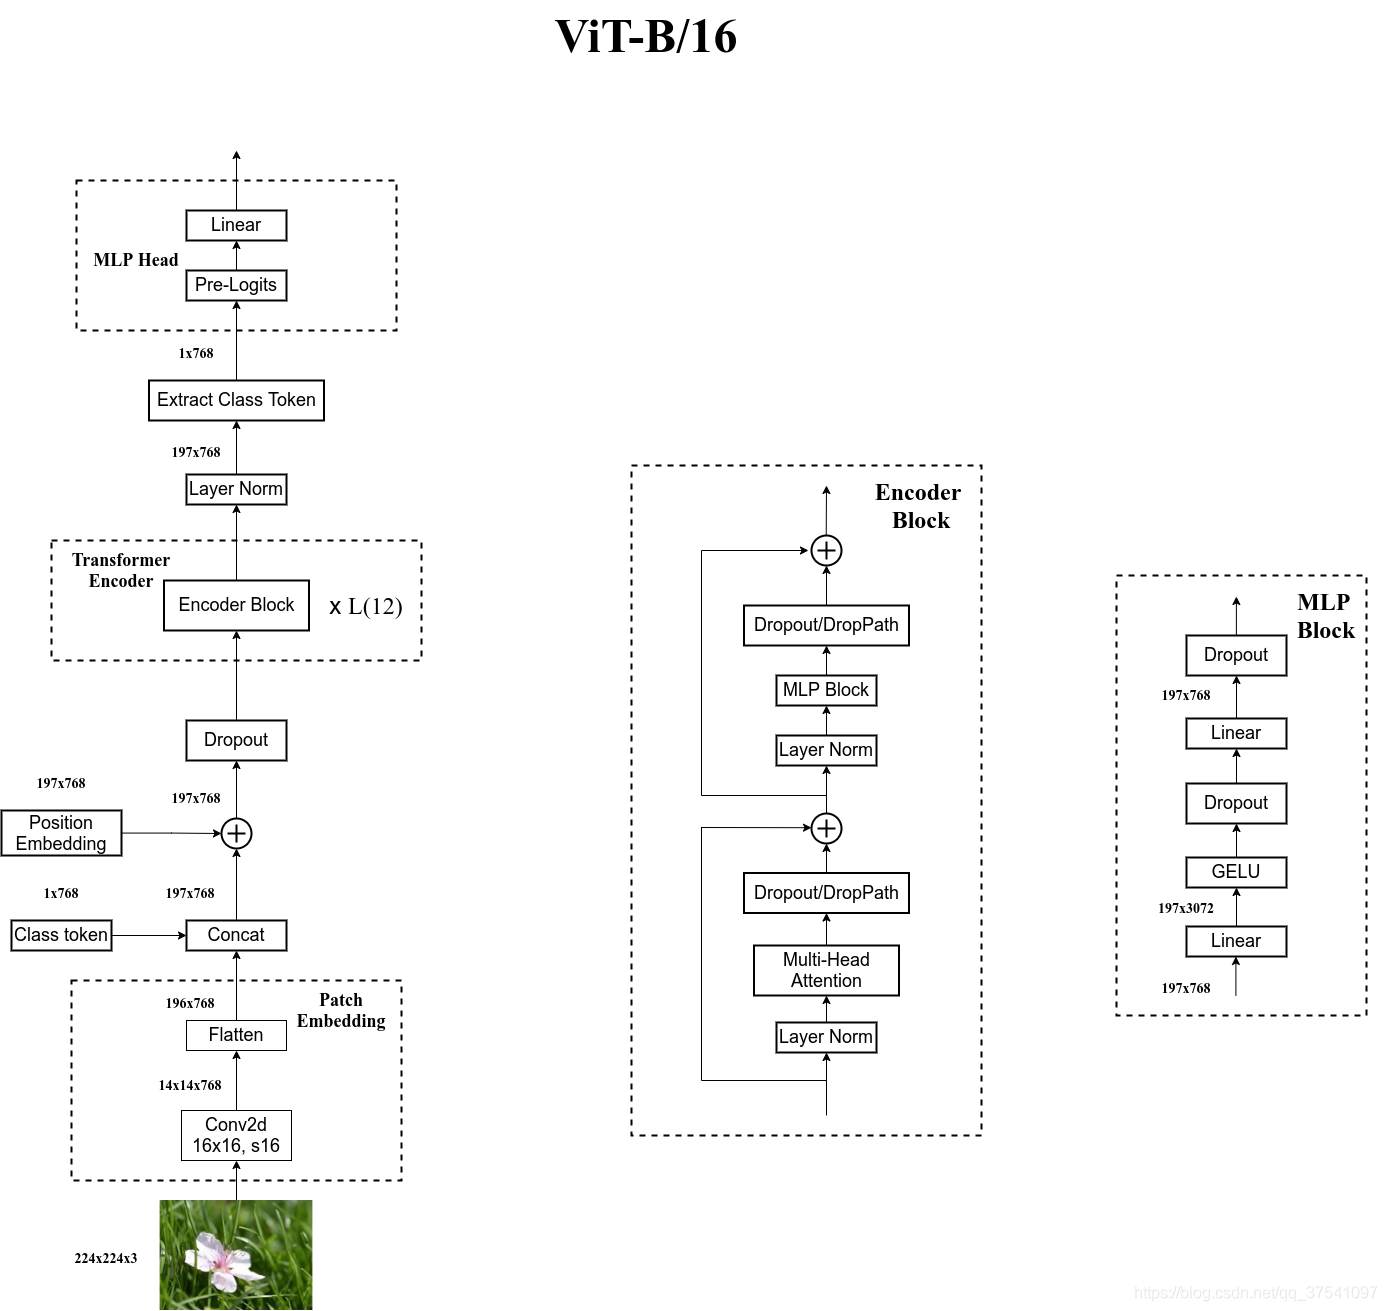

# 1.import required libraries

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

## 2. setup device-agnostic code

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 3. set the seed


In [65]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

## 4. set the hyperpeameters

In [129]:
BATCH_SIZE = 128
EPOCHS = 30
LEARNING_RATE = 3e-4 #10的-4次方*3 0.0003
PATCH_SIZE = 4
NUM_CLASSES = 10
IMAGE_SIZE = 32
CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 16
DEPTH = 6
MLP_DIM = 512
DROP_RATE = 0.1

## 5. define image transformations

In [90]:
transform = transforms.Compose([
    transforms.ToTensor(),# 0-255 pixel vaule to 0.0-1.0
    transforms.Normalize((0.5),(0.5)) #This process adjusts the values to a mean of 0 and a standard deviation of 1, scaling the range to [-1.0, 1.0].
    # 1. Helps the model to converge faster
    # 2. Helps to make the numerical computations stable
])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

## 6. gettting a dataset

In [91]:
train_dataset = datasets.CIFAR10(root="data",train=True,download=True,transform=transform_train)

In [92]:
test_dataset = datasets.CIFAR10(root="data",train=False,download=True,transform=transform)

## 7. convert our datasets into dataloaders


In [93]:
train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

## 8. Building Vision Transformer Model From Scratch

In [103]:
class PatchEmbedding(nn.Module):
  def __init__(self,img_size,patch_size,in_channels,embed_dim):
    super().__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_channels=in_channels,
                              out_channels=embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size) #輸出為[B ,C, H, W]  B batch size C=embed_dim H,W=HorW//patch_size
    num_patches = (img_size // patch_size) ** 2 # N = H*W/P²
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))#生成cls_token Tensor 並運用nn.Parameter()讓cls_token可以最優化 使用nn.Parameter()的目的也是想让某些变量在学习的过程中不断的修改其值以达到最优化
    self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))#生成位置 Tensor 並運用nn.Parameter()讓pos_embed可以最優化

  def forward(self, x:torch.Tensor):
    B = x.size(0)#獲取Tensor的維度 也就是batch size
    #flatten: [B ,C, H, W] -> [B, C ,H*W] B batch size C channel=embed_dim
    #transpose: [B, C ,H*W] ->  [B,H*W, C]
    x = self.proj(x) # (B, embed_dim, H//P, W//P)
    x = x.flatten(2).transpose(1, 2) # (B, num_patches, embed_dim)
    cls_tokens = self.cls_token.expand(B, -1, -1) # -1 means not changing the size of that dimension
    x = torch.cat((cls_tokens, x), dim=1)# 把CLS_token加進去X
    x = x + self.pos_embed #加入位置
    return x


In [104]:
class MLP(nn.Module):
   def __init__(self,
                 in_features,
                 hidden_features,
                 drop_rate): #in_features輸入的維度 hidden_features hidden_layer的維度通常為in_features的4倍
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=hidden_features)
        self.fc2 = nn.Linear(in_features=hidden_features,
                             out_features=in_features)
        self.dropout = nn.Dropout(drop_rate)

   def forward(self, x):
        x = self.dropout(F.gelu(self.fc1(x)))
        x = self.dropout(self.fc2(x))
        return x

In [105]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=drop_rate, batch_first=True) #batch_first – If True, then the input and output tensors are provided as (batch, seq, feature). Default: False (seq, batch, feature).
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, drop_rate)

    def forward(self, x):#     q              k              v
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0] #+為Residual Connection  nn.MultiheadAttention的ouput type為tuple[torch.Tensor, Optional[torch.Tensor]] 分別為attn_output, attn_output_weights [0]->**attn_output** - Attention outputs of shape
        x = x + self.mlp(self.norm2(x))
        return x

In [106]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, depth, num_heads, mlp_dim, drop_rate):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_rate)
            for _ in range(depth)#重複depth次 讓[]裡面有depth個TransformerEncoderLayer
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) #MLP Head

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.norm(x)
        cls_token = x[:, 0]
        return self.head(cls_token)

In [130]:
# Instantiate model
model = VisionTransformer(
    IMAGE_SIZE, PATCH_SIZE, CHANNELS, NUM_CLASSES,
    EMBED_DIM, DEPTH, NUM_HEADS, MLP_DIM, DROP_RATE
).to(device) #.to(device)的意思是将所有最开始读取数据时的tensor变量copy一份到device所指定的GPU上去，之后的运算都在GPU上进行。

## 9. Defining a Loss function and an optimizer

In [131]:
criterion = nn.CrossEntropyLoss() # Measure how wrong the model is CrossEntropyLoss() use when 要分類的class大於2  2個class時用BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), # update our model's parameters to try and reduce the loss
                             lr=LEARNING_RATE)

## 10. Defining a Training Loop function

In [132]:
def train(model, loader, optimizer, criterion):
    # Set the mode of the model into training
    model.train()

    total_loss, correct = 0, 0

    for x, y in loader: #x batch of images y batch of labels
        # Moving (Sending) our data into the target device
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        # 1. Forward pass (model outputs raw logits)
        out = model(x)
        # 2. Calcualte loss (per batch)
        loss = criterion(out, y)
        # 3. Perform backpropgation
        loss.backward()
        # 4. Perforam Gradient Descent
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    # You have to scale the loss (Normlization step to make the loss general across all batches)
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [133]:
def evaluate(model, loader):
    model.eval() # Set the mode of the model into evlauation
    correct = 0
    with torch.inference_mode():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(dim=1) == y).sum().item()
    return correct / len(loader.dataset)

In [81]:
from tqdm.auto import tqdm

In [120]:
### Training
train_accuracies, test_accuracies = [], []

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch: {epoch+1}/{EPOCHS}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}%, Test acc: {test_acc:.4f}")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1/20, Train loss: 1.9116, Train acc: 0.3000%, Test acc: 0.4356
Epoch: 2/20, Train loss: 1.6403, Train acc: 0.4047%, Test acc: 0.4832
Epoch: 3/20, Train loss: 1.5241, Train acc: 0.4492%, Test acc: 0.5139
Epoch: 4/20, Train loss: 1.4493, Train acc: 0.4787%, Test acc: 0.5397
Epoch: 5/20, Train loss: 1.3834, Train acc: 0.5015%, Test acc: 0.5568
Epoch: 6/20, Train loss: 1.3286, Train acc: 0.5248%, Test acc: 0.5775
Epoch: 7/20, Train loss: 1.2752, Train acc: 0.5420%, Test acc: 0.5778
Epoch: 8/20, Train loss: 1.2332, Train acc: 0.5572%, Test acc: 0.5980
Epoch: 9/20, Train loss: 1.1818, Train acc: 0.5784%, Test acc: 0.6160
Epoch: 10/20, Train loss: 1.1378, Train acc: 0.5928%, Test acc: 0.6303
Epoch: 11/20, Train loss: 1.1003, Train acc: 0.6085%, Test acc: 0.6402
Epoch: 12/20, Train loss: 1.0666, Train acc: 0.6180%, Test acc: 0.6431
Epoch: 13/20, Train loss: 1.0347, Train acc: 0.6331%, Test acc: 0.6433
Epoch: 14/20, Train loss: 1.0034, Train acc: 0.6448%, Test acc: 0.6680
Epoch: 15/20, T

In [121]:
train_accuracies

[0.29998,
 0.4047,
 0.44922,
 0.47868,
 0.5015,
 0.52482,
 0.54198,
 0.55724,
 0.57836,
 0.59282,
 0.60848,
 0.61804,
 0.63308,
 0.64478,
 0.65158,
 0.65826,
 0.67304,
 0.67984,
 0.685,
 0.69444]

In [122]:
test_accuracies

[0.4356,
 0.4832,
 0.5139,
 0.5397,
 0.5568,
 0.5775,
 0.5778,
 0.598,
 0.616,
 0.6303,
 0.6402,
 0.6431,
 0.6433,
 0.668,
 0.6752,
 0.6749,
 0.6912,
 0.7,
 0.6974,
 0.6963]

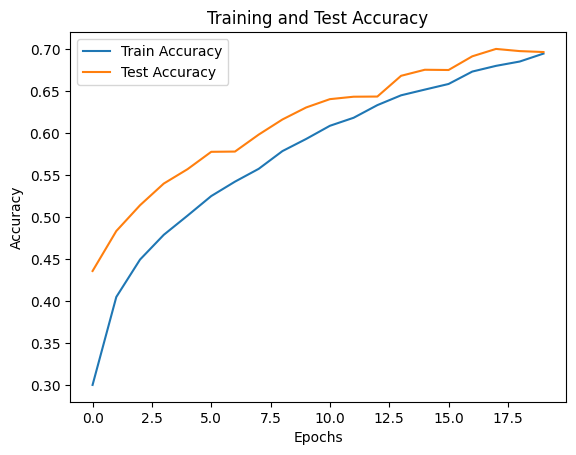

In [123]:
# Plot accuracy
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")
plt.show()

In [30]:
import random

In [124]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to(device)
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5 # Unormalize our images to be able to plot them with matplotlib
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            truth = classes[true_label] == classes[predicted.item()]
            if truth:
                color = "g"
            else:
                color = "r"

            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=color)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

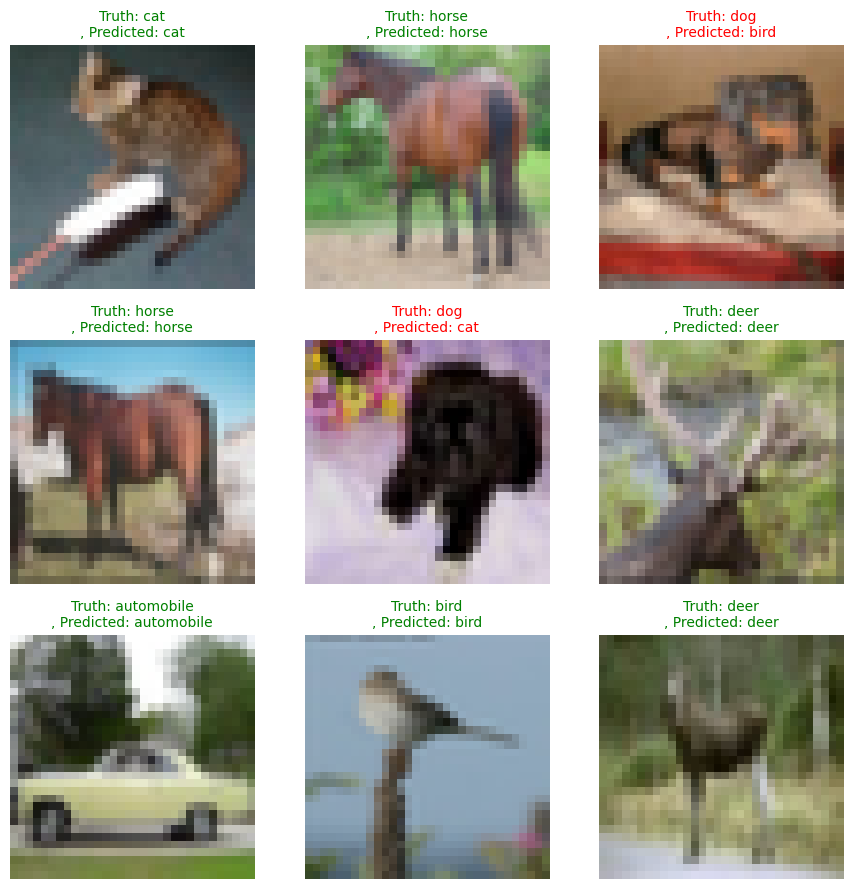

In [128]:
predict_and_plot_grid(model, test_dataset, classes=train_dataset.classes, grid_size=3)